In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
import optuna

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks", {'axes.grid': True})
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
RANDOM_STATE = 42
results = pd.DataFrame(columns = ['model', 'task', 'accuracy'])

def show_results(df=results):
    plt.figure(figsize=(5, len(df) * 0.3))
    ax = sns.barplot(data=df, y='model', x='accuracy', palette='tab10')
    ax.set(xlim=(df.accuracy.min() * 0.99, df.accuracy.max() * 1.01))
    for i in ax.containers:
        ax.bar_label(i, fmt='%.4f')

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [3]:
data = pd.read_csv('data/winequality-red.csv', sep = ';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


1.Разделите выборку на обучающую и тестовую в отношении 70%/30%, предварительно выделив целевую переменную (колонка 'quality').

In [4]:
X = data.drop(columns='quality')
y_encoder = LabelEncoder().fit(data['quality'])
y = y_encoder.transform(data['quality'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1119, 11), (1119,), (480, 11), (480,))

2.Оцените качество на тестовой выборке по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [5]:
def fit_acc(model):
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

In [6]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
bag = BaggingClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)

acc_DT = fit_acc(dt)
acc_Bagging = fit_acc(bag)
acc_RF = fit_acc(rf)
results.loc[0] = ['DecisionTreeClassifier', 'task2', acc_DT]
results.loc[1] = ['BaggingClassifier ', 'task2', acc_Bagging]
results.loc[2] = ['RandomForestClassifier', 'task2', acc_RF]

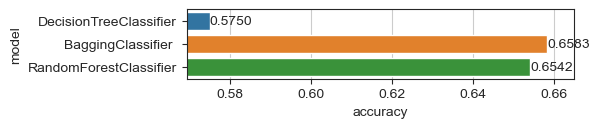

In [7]:
show_results()

# Выводы:
# * ансамбли деревьев работают гораздо лучше одного дерева

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [8]:
n_trees = [10, 50, 100] + list(range(200, 5001, 200))
rf_acc = [fit_acc(RandomForestClassifier(n, random_state=RANDOM_STATE, n_jobs=4)) for n in n_trees]

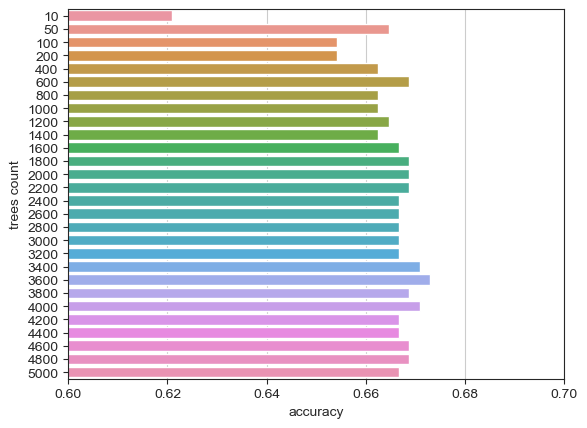

In [9]:
ax = sns.barplot(y=n_trees, x=rf_acc, orient='h')
ax.set(xlim=(0.6, 0.7), xlabel='accuracy', ylabel='trees count');

# Выводы:
# * 50 деревьев дают значительный прирост качества по сравнению с 10. Дальше качество не сильно меняется
# * Максимальное качество достигается на 3600 деревьях, но такое большое их количество может приводить 
#   к переобучению (модель просто запомнит обучающую выборку)
# * 50 и 600 деревьев выглядят самыми лучшими вариантами

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [10]:
def cv_acc(model):
    return cross_val_score(model, X, y, scoring='accuracy', n_jobs=4).mean()

In [11]:
acc_sklearn = cv_acc(GradientBoostingClassifier(random_state=RANDOM_STATE))
acc_xgboost = cv_acc(xgb.XGBClassifier(random_state=RANDOM_STATE))
results.loc[3] = ['GradientBoostingClassifier', 'task4', acc_sklearn]
results.loc[4] = ['XGBClassifier', 'task4', acc_xgboost]

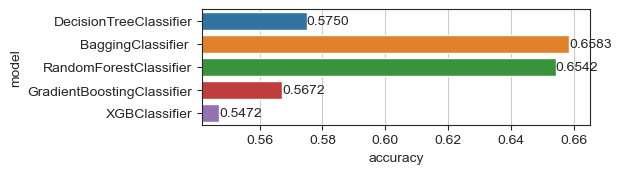

In [12]:
show_results()

# Выводы:
# * обе модели с параметрами по-умолчанию показали результат гораздо хуже случайного леса
# * не совсем корректно сравнивать метрики для моделей с кроссвалидацией по всему датасету и валидацией по тестовой выборке
#   (качество модели зависит от способа разбиения данных; вероятно, метрики сильно изменятся при другом разбиении)
# * если посчитать качество по тестовой выборке (fit_acc(model)), то качество будет сопоставимо со случайным лесом
# * кроссвалидация по всему датасету дает более объективную оценку качества модели

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy. Выведите лучшие параметры алгоритмов.

In [13]:
params_grid = {
    'random_state': [RANDOM_STATE],
    'learning_rate': np.linspace(0.01, 1, 10),
    'n_estimators': range(100, 401, 100),
    'max_depth': np.arange(3, 7)
}

In [14]:
grid_sklearn = GridSearchCV(GradientBoostingClassifier(), params_grid, cv=3, n_jobs=6)
grid_xgboost = GridSearchCV(xgb.XGBClassifier(n_jobs=2), params_grid, cv=3, n_jobs=6)

acc_sklearn_cv = fit_acc(grid_sklearn)
acc_xgboost_cv = fit_acc(grid_xgboost)
best_params_sklearn = grid_sklearn.best_params_
print('Параметры лучшей модели sklearn:\n', best_params_sklearn)
best_params_xgboost = grid_xgboost.best_params_
print('Параметры лучшей модели xgboost:\n', best_params_xgboost)
results.loc[5] = ['GradientBoostingClassifier_CV', 'task5', acc_sklearn_cv]
results.loc[6] = ['XGBClassifier_CV', 'task5', acc_xgboost_cv]

Параметры лучшей модели sklearn:
 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'random_state': 42}
Параметры лучшей модели xgboost:
 {'learning_rate': 0.56, 'max_depth': 5, 'n_estimators': 100, 'random_state': 42}


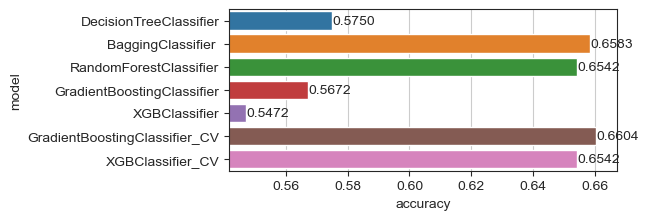

In [15]:
show_results()

# Выводы:
# * с подобранными параметрами бустинги не показали значимого прироста качества по сравнению со случайным лесом

6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [16]:
acc_lightgbm = cv_acc(lgb.LGBMClassifier(random_state=RANDOM_STATE))
acc_catboost = cv_acc(cat.CatBoostClassifier(random_state=RANDOM_STATE, verbose=0))
results.loc[7] = ['LGBMClassifier', 'task6', acc_lightgbm]
results.loc[8] = ['CatBoostClassifier', 'task6', acc_catboost]

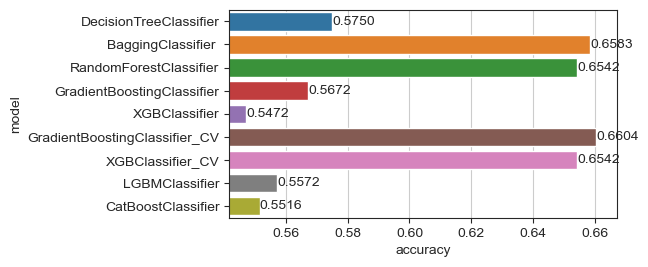

In [17]:
show_results()

# Выводы:
# * будем сравнивать результаты только с метриками моделей, обученных с кроссвалидацией по всему датасету
# * из 4-х моделей бустинг от sklearn (GradientBoostingClassifier) выдал лучшую метрику

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями.
Сравните значение метрики accuracy. Выведите лучшие параметры алгоритмов.

In [18]:
grid_lightgbm = GridSearchCV(lgb.LGBMClassifier(n_jobs=2), params_grid, cv=3, n_jobs=6)
grid_catboost = GridSearchCV(cat.CatBoostClassifier(verbose=0), params_grid, cv=3, n_jobs=6)

acc_lightgbm_cv = fit_acc(grid_lightgbm)
acc_catboost_cv = fit_acc(grid_catboost)
best_params_lightgbm = grid_lightgbm.best_params_
print('Параметры лучшей модели lightgbm:\n', best_params_lightgbm)
best_params_catboost = grid_catboost.best_params_
print('Параметры лучшей модели catboost:\n', best_params_catboost)
results.loc[9] = ['LGBMClassifier_CV', 'task7', acc_lightgbm_cv]
results.loc[10] = ['CatBoostClassifier_CV', 'task7', acc_catboost_cv]

Параметры лучшей модели lightgbm:
 {'learning_rate': 0.23, 'max_depth': 6, 'n_estimators': 100, 'random_state': 42}
Параметры лучшей модели catboost:
 {'learning_rate': 0.67, 'max_depth': 6, 'n_estimators': 300, 'random_state': 42}


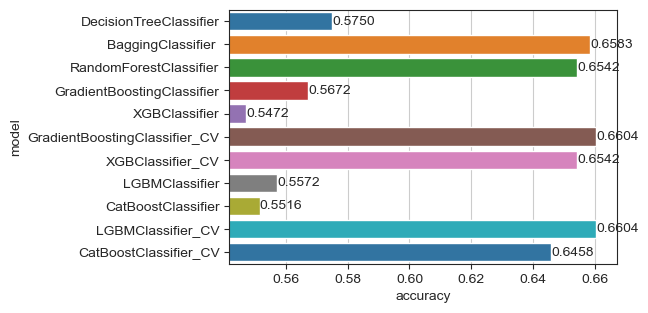

In [19]:
show_results()

# Выводы:
# * будем сравнивать результаты только с метриками моделей, обученных на {X_train, y_train}
# * все 4 модели бустинга с подобранными параметрами не показали значимого прироста по сравнению со случайным лесом
# * catboost показал самый плохой результат

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [optuna](https://github.com/optuna/optuna) . Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [20]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5),
        'n_estimators': trial.suggest_categorical('n_estimators', range(50, 501, 10)),
        'max_depth': trial.suggest_categorical('max_depth', range(1, 16))
    }
    return cv_acc(xgb.XGBClassifier(n_jobs=2, **params))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, n_jobs=6, show_progress_bar=True)

/opt/homebrew/Caskroom/miniconda/base/envs/ml310/lib/python3.10/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
best_params_xgboost_optuna = study.best_params
print('Параметры лучшей модели xgboost:\n', best_params_xgboost_optuna)
acc_xgboost_optuna = study.best_value
results.loc[11] = ['XGBClassifier_optuna', 'task8', acc_xgboost_optuna]

Параметры лучшей модели xgboost:
 {'learning_rate': 0.007975157676144096, 'n_estimators': 80, 'max_depth': 5}


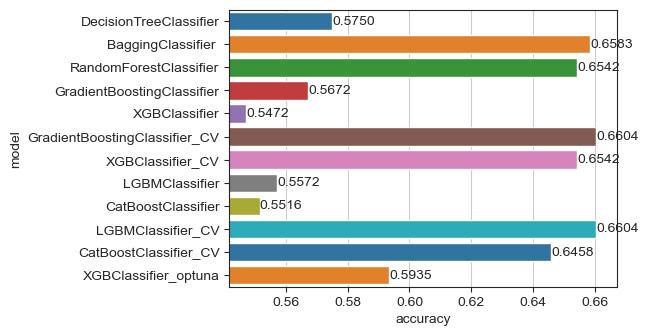

In [22]:
show_results()

# Выводы:
# * т.к. обучали модель с кроссвалидацией по всему датасету, то будем сравнивать с результатами из задач 4 и 6
# * качество с optuna стало значительно лучше чем для бустинга от sklearn (GradientBoostingClassifier)

9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [23]:
stack = StackingClassifier([
    ('sklearn', GradientBoostingClassifier(random_state=RANDOM_STATE)),
    ('xgboost', xgb.XGBClassifier(random_state=RANDOM_STATE)),
    ('lightgbm', lgb.LGBMClassifier(random_state=RANDOM_STATE)),
    ('catboost', cat.CatBoostClassifier(random_state=RANDOM_STATE, verbose=0))
], LogisticRegression(max_iter=200))

acc_stacking_default = cv_acc(stack)
results.loc[12] = ['Stacking default', 'task9', acc_stacking_default]

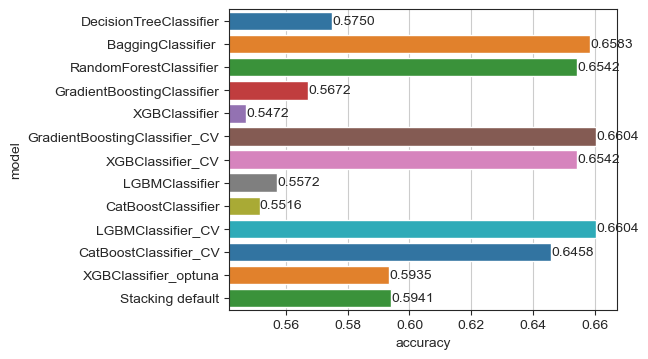

In [24]:
show_results()

# Выводы:
# * стэкинг 4-х вариантов бустинга показал метрику, сопоставимую с optuna

10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [25]:
stack_opt = StackingClassifier([
    ('sklearn', GradientBoostingClassifier(**best_params_sklearn)),
    ('xgboost', xgb.XGBClassifier(n_jobs=2, **best_params_xgboost)),
    ('lightgbm', lgb.LGBMClassifier(n_jobs=2, **best_params_lightgbm)),
    ('catboost', cat.CatBoostClassifier(verbose=0, **best_params_catboost))
], LogisticRegression(max_iter=200))

acc_stacking = cv_acc(stack_opt)
results.loc[13] = ['Stacking', 'task10', acc_stacking]

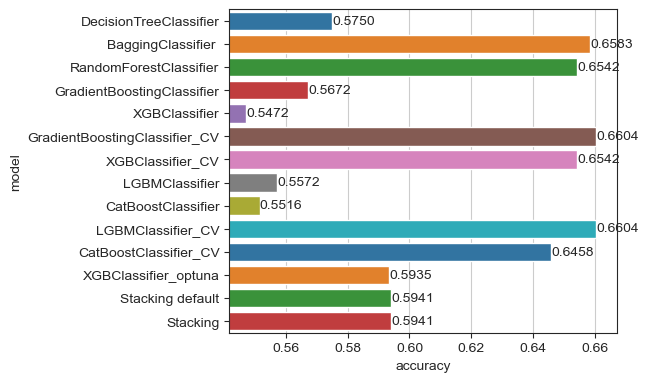

In [26]:
show_results()

# Выводы:
# * разницы между настроенными и не настроенными бустингами не заметно
# * в итоге optuna и стэкинг над градиентными бустингами показали лучшие результаты с кроссвалидацией по всему датасету

In [27]:
results

,model,task,accuracy
0,DecisionTreeClassifier,task2,0.575000
1,BaggingClassifier,task2,0.658333
2,RandomForestClassifier,task2,0.654167
3,GradientBoostingClassifier,task4,0.567222
4,XGBClassifier,task4,0.547234
5,GradientBoostingClassifier_CV,task5,0.660417
6,XGBClassifier_CV,task5,0.654167
7,LGBMClassifier,task6,0.557247
8,CatBoostClassifier,task6,0.551611
9,LGBMClassifier_CV,task7,0.660417
